# XGBOOST

## 1. Imports

Importem totes les llibreries necessàries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                              roc_curve, ConfusionMatrixDisplay, f1_score, 
                              precision_score, recall_score, balanced_accuracy_score,
                              average_precision_score)
import matplotlib.pyplot as plt

## 2. Càrrega i preparació de dades

Carreguem les dades del dataset, eliminem les característiques redundants segons l'anàlisi exploratori, identifiquem les variables numèriques i les categòriques, i dividim el dataset en entrenament i validació.

In [3]:
df = pd.read_csv('trs_train.csv')

# Eliminació de variables identificades a l'anàlisi
variables_eliminar = ['patient_id', 'Glucose', 'Ki_whole_striatum', 
                      'Ki_associative_striatum', 'SUVRc_associative_striatum']
df = df.drop(columns=variables_eliminar, errors='ignore')

# Separar variable objectiu
X = df.drop(columns=['TRS'])
y = df['TRS']

# Identificar columnes numèriques i categòriques
categorical_columns = ['Sex', 'Ethnicity', 'Family_history', 'Prior_antipsychotics', 
                       'CYP2D6_metabolic_phenotype', 'HLA_DRB1_04_02', 'HLA_B_15_02', 
                       'HLA_A_31_01', 'Del_22q11_2_status']

numerical_columns = [col for col in X.columns if col not in categorical_columns]
print(f"Variables numèriques: {len(numerical_columns)}")
print(f"Variables categòriques: {len(categorical_columns)}")

# Divisió train-test (80-20) amb estratificació
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} mostres")
print(f"Test set: {X_test.shape[0]} mostres")
print(f"Distribució train: {y_train.value_counts().to_dict()}")
print(f"Distribució test: {y_test.value_counts().to_dict()}")

Variables numèriques: 13
Variables categòriques: 9

Train set: 7200 mostres
Test set: 1800 mostres
Distribució train: {0: 4930, 1: 2270}
Distribució test: {0: 1232, 1: 568}


## 3. Preprocessament

Pipeline complet de preprocessament.
Per a les característiques numèriques, imputem amb la funció `SimpleImputer` mitjanant la mediana. 
Per a les característiques categòriques, imputem amb la funció `SimpleImputer` el valor més frequent. Codifiquem amb `OneHotEncoder` per a un correcte funcionament del nostre model.

Cridem la funció `XGBClassifier` de sklearn, la implementació del nostre SVM.

In [4]:
# Transformador per variables numèriques
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Transformador per variables categòriques
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ColumnTransformer que combina ambdós
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Pipeline complert amb XGBoost (amb regularització)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        reg_alpha=0.1,  
        reg_lambda=1.0,  
        min_child_weight=3,  
        gamma=0.1  
    ))
])

## 4. Grid search amb validació creuada

Fem una cerca per trobar els hiperparàmetres que maximitzen F1 score. Definim la graella de cerca amb els hiperparàmetres i realitzem un grid search amb validació creuada (5-fold CV).

Un cop acabada la cerca, imprimim la combinació d'hiperparàetres escollida i el valor d'F1-macro.

In [5]:
# 3.1. Definir grilla de paràmetres per XGBoost (amb regularització anti-overfitting)
param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # Menys arbres
    'classifier__max_depth': [2, 3, 4],  # Arbres menys profunds
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Learning rate més baix
    'classifier__subsample': [0.6, 0.8],  # Menys mostres per arbre
    'classifier__colsample_bytree': [0.6, 0.8],  # Menys features per arbre
    'classifier__min_child_weight': [3, 5, 7],  # Mínim pes per fulles
    'classifier__gamma': [0.1, 0.5, 1.0],  # Penalització per complexitat
    'classifier__reg_alpha': [0.1, 0.5, 1.0],  # L1 regularization
    'classifier__reg_lambda': [1.0, 2.0, 5.0],  # L2 regularization
    'classifier__scale_pos_weight': [2, 3]  # Per gestionar el desequilibri
}


grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("\n" + "="*70)
print("INICIANT GRID SEARCH AMB VALIDACIÓ CREUADA (5-fold) - XGBOOST")
print("="*70)

grid_search.fit(X_train, y_train)

# 3.3. Millors paràmetres
print("\n" + "="*70)
print("MILLORS PARÀMETRES")
print("="*70)
print(f"Millors paràmetres: {grid_search.best_params_}")
print(f"Millor F1-Macro (CV): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_


INICIANT GRID SEARCH AMB VALIDACIÓ CREUADA (5-fold) - XGBOOST
Fitting 5 folds for each of 17496 candidates, totalling 87480 fits

MILLORS PARÀMETRES
Millors paràmetres: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 5.0, 'classifier__scale_pos_weight': 2, 'classifier__subsample': 0.6}
Millor F1-Macro (CV): 0.5896


c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:38:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Avaluació del model

Un cop tenim el model preparat, procedim amb la seva validació sobre el conjunt de test.

Comencem imprimint el classification report, amb les mètriques d'avaluació del nostre model.

In [8]:
# Prediccions en test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("AVALUACIÓ EN TEST SET")
print("="*70)


# Classification report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


AVALUACIÓ EN TEST SET

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1232
           1       0.41      0.51      0.46       568

    accuracy                           0.61      1800
   macro avg       0.58      0.59      0.58      1800
weighted avg       0.64      0.61      0.62      1800


ROC-AUC Score: 0.6251


Visualitzem la matriu de confusió i la corba ROC.

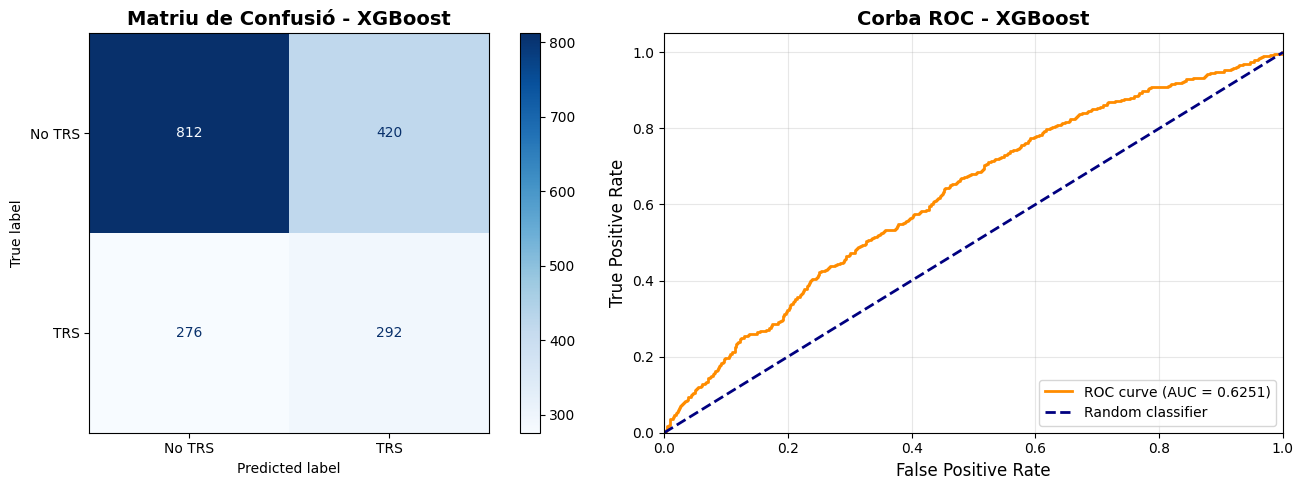

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
# Matriu de confusió visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['No TRS', 'TRS'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriu de Confusió - XGBoost', fontsize=14, fontweight='bold')

# Corba ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Corba ROC - XGBoost', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('xgboost_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

Visualitzem un gràfic de barres comparant les mètriques d'avaluació per el conjunt d'entrenament i el test.


COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)
Mètrica                   Train        Test         Diferència  
----------------------------------------------------------------------
F1-Macro                       0.6235      0.5781      0.0454
F1-Binary (TRS)                0.5090      0.4562      0.0527
ROC-AUC                        0.6903      0.6251      0.0652
PR-AUC                         0.5029      0.4205      0.0824
Recall (TRS)                   0.5617      0.5141      0.0476
Precision (TRS)                0.4653      0.4101      0.0552
Balanced Accuracy              0.6323      0.5866      0.0457


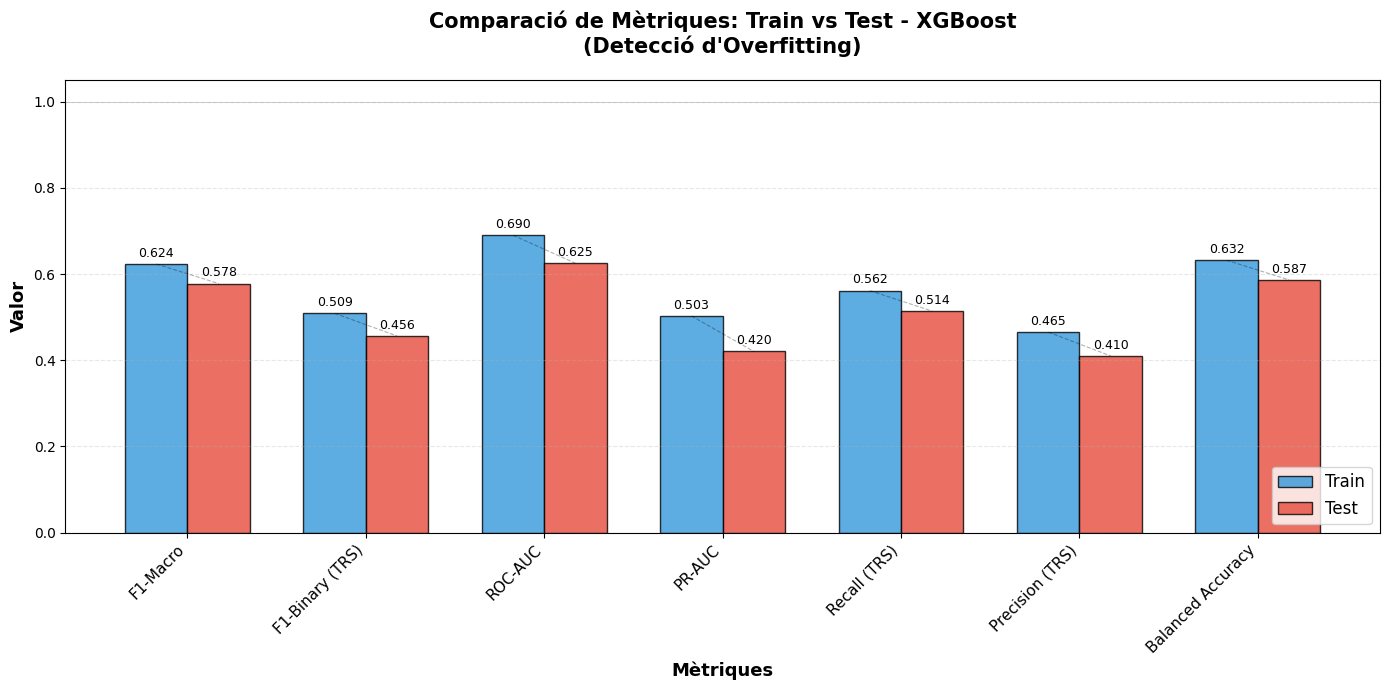

In [10]:
# Calcular prediccions per al conjunt de train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Calcular mètriques per train
train_metrics = {
    'F1-Macro': f1_score(y_train, y_train_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_train, y_train_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_train, y_train_pred_proba),
    'PR-AUC': average_precision_score(y_train, y_train_pred_proba),
    'Recall (TRS)': recall_score(y_train, y_train_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_train, y_train_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_train, y_train_pred)
}

# Calcular mètriques per test
test_metrics = {
    'F1-Macro': f1_score(y_test, y_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_test, y_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_pred_proba),
    'Recall (TRS)': recall_score(y_test, y_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_test, y_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
}

# Mostrar mètriques per pantalla
print("\n" + "="*70)
print("COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)")
print("="*70)
print(f"{'Mètrica':<25} {'Train':<12} {'Test':<12} {'Diferència':<12}")
print("-" * 70)

for metric_name in train_metrics.keys():
    train_val = train_metrics[metric_name]
    test_val = test_metrics[metric_name]
    diff = train_val - test_val
    print(f"{metric_name:<25} {train_val:>11.4f} {test_val:>11.4f} {diff:>11.4f}")



fig, ax = plt.subplots(figsize=(14, 7))

metrics_names = list(train_metrics.keys())
train_values = list(train_metrics.values())
test_values = list(test_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, train_values, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_values, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Afegir línies per mostrar diferències
for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
    if train_val > test_val:
        ax.plot([i - width/2, i + width/2], [train_val, test_val], 
                'k--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Mètriques', fontsize=13, fontweight='bold')
ax.set_ylabel('Valor', fontsize=13, fontweight='bold')
ax.set_title('Comparació de Mètriques: Train vs Test - XGBoost\n(Detecció d\'Overfitting)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=1.0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Afegir valors sobre les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('xgboost_train_vs_test_metrics.png', dpi=300, bbox_inches='tight')
plt.show()